# Lecture 1 Basic Ideas of Spectral Method

## Think Globally. Act locally. 
##                   -- Patrick Geddes, a social activist and a town planner



### Finite Difference (FD), Finite Element (FE), Finite Volume (FV) methods are **local**. 

Finite Difference (FD) methods approximate derivatives of a function by local arguments, such as 
$$
u'(x) \simeq \frac{u(x+h)-u(x-h)}{2h} 
$$

### Differentiation Matrices

To be specific, consider a uniform grid $\{x_1,...,x_N\}$, with $X_{j + l} - x_j = h$ for each $j$ , and a set of corresponding data values $\{u_l, ...,u_N\}$:

The above discrete differentiation can be represented as a matrix multiplication


$$
  \left( {\begin{array}{c} w_1 \\ \\ \vdots \\ \\ w_N \end{array}} \right) =
  h^{-1}\left( {\begin{array}{cccc}
    0 & \frac12 &  &  & -\frac12 \\
    -\frac12 & 0 & \ddots &  & \\
     &  & \ddots & & \\
     &  & \ddots & 0 & \frac12 \\
    \frac12 & & & -\frac12 & 0
  \end{array} } \right)
  \left( {\begin{array}{c} u_1 \\ \\ \vdots \\ \\ u_N \end{array}} \right)
$$

 The matrix is 
 - Toeplitz: constant along diagonals, namely $a_{ij}$ only depends on $i-j$, 
 - circulant: $a_{ij}$ only depends on $(i-j)(mod N)$. 
 
**Exercise 1**
Can you find a first order and third order finite difference formula for $u'$? write their differentiation matrices.


**Example**
Let us compute the derivative of $$ u(x) = \exp(\sin(x)), \qquad x \in [-\pi,\pi] $$ using fourth order finite difference scheme $$ u'(x_j) \approx w_j = \frac{1}{h} \left( \frac{1}{12} u_{j-2} - \frac{2}{3} u_{j-1} + \frac{2}{3} u_{j+1} - \frac{1}{12} u_{j+2} \right) $$ using periodic boundary conditions.

$$
  \left( {\begin{array}{c} w_1 \\ \\ \\ \vdots \\ \\ \\ w_N \end{array}} \right) =
  h^{-1}\left( {\begin{array}{ccccccc}
     &  & \ddots & & & \frac{1}{12} & -\frac{2}{3} \\
     &  & \ddots & -\frac{1}{12} & & & \frac{1}{12} \\
     &  & \ddots & \frac{2}{3} & \ddots & &  \\
     &  & \ddots & 0 & \ddots & &  \\
     &  & \ddots & -\frac{2}{3} & \ddots & &  \\
     -\frac{1}{12} &  &  & \frac{1}{12} & \ddots & &  \\
     \frac{2}{3} & -\frac{1}{12} &  &  & \ddots & &  \\
  \end{array} } \right)
   \left( {\begin{array}{c} u_1 \\ \\ \\ \vdots \\ \\ \\ u_N \end{array}} \right) 
$$


In [1]:
%matplotlib inline
%config InlineBackend.figure_format='svg'
from scipy.linalg import toeplitz
from scipy.sparse import coo_matrix
from numpy import pi,ones,arange,exp,sin,cos,zeros,tan,inf
from numpy.linalg import norm
from matplotlib.pyplot import figure,semilogy,loglog,text,title,grid,xlabel,ylabel


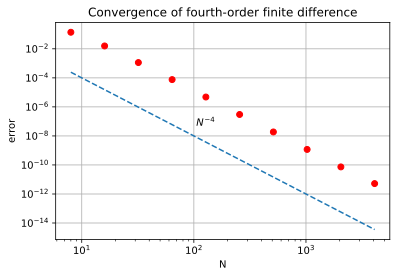

In [2]:
# Program 1
Nvec = 2**arange(3,13)
for N in Nvec:
    h = 2*pi/N
    x = -pi + arange(1,N+1)*h
    u = exp(sin(x))
    uprime = cos(x)*u
    e = ones(N)
    e1 = arange(0,N)
    e2 = arange(1,N+1); e2[N-1]=0
    e3 = arange(2,N+2); e3[N-2]=0; e3[N-1]=1;
    D = coo_matrix((2*e/3,(e1,e2)),shape=(N,N)) \
        - coo_matrix((e/12,(e1,e3)),shape=(N,N))
    D = (D - D.T)/h
    error = norm(D.dot(u)-uprime,inf)
    loglog(N,error,'or')
    #hold(True)
    
semilogy(Nvec,Nvec**(-4.0),'--')
text(105,5e-8,'$N^{-4}$')
grid(True)
xlabel('N')
ylabel('error')
title('Convergence of fourth-order finite difference');


We have looked at second- and fourth-order finite differences, and it is clear that consideration of sixth-, eighth-, and higher order schemes will lead to circulant matrices of increasing bandwidth. The idea behind spectral methods is to take this process to the limit, at least in principle, and work with a differentiation formula of infinite order and infinite bandwidth - i.e., a _dense matrix_

For finite $N$, taking $N$ even for simplicity, here is the $N \times N$ dense matrix we will derive for a periodic, regular grid:
$$
D =  \left( {\begin{array}{ccccccccc}
     &  &  &  & \vdots &  &  &  &  \\
     &  &  \ddots &  & \frac12\cot{\frac{3h}{2}} &  &  & & \\
     &  &  \ddots &  & -\frac12\cot{\frac{2h}{2}} &  &  & & \\
     &  &  \ddots &  & \frac12\cot{\frac{h}{2}} &  &  & & \\
     &  &  &  & 0 &  &  & & \\
     &  &  &  & -\frac12\cot{\frac{1h}{2}} &  & \ddots &  & \\
     &  &  &  & \frac12\cot{\frac{2h}{2}} &  & \ddots &  & \\
     &  &  &  & -\frac12\cot{\frac{3h}{2}} &  & \ddots &  & \\
     &  &  &  & \vdots &  &  & & \\
  \end{array} } \right)
$$

### Spectral methods are **global**. 

We repeat program P1 using periodic spectral method to compute derivative of $$ u(x) = \exp(\sin(x)), \qquad x \in [-\pi,\pi] $$


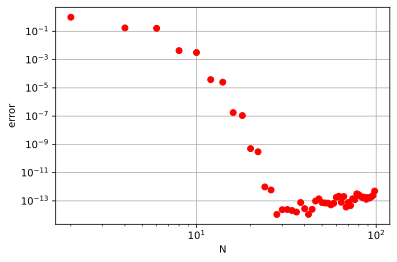

In [3]:
# Program 2
figure()
for N in range(2,100,2):
    h = 2.0*pi/N
    x = -pi + arange(1,N+1)*h
    u = exp(sin(x))
    uprime = cos(x)*u #Exact derivative
    col = zeros(N)
    col[1:] = 0.5*(-1.0)**arange(1,N)/tan(arange(1,N)*h/2.0)
    row = zeros(N); row[0] = col[0]; row[1:] = col[N-1:0:-1]
    D = toeplitz(col,row)
    error = norm(D.dot(u)-uprime,inf)
    loglog(N,error,'or')
    
grid(True)
xlabel('N')
ylabel('error');


Program 2 is the same as Program 1 except the differential matrix is different. What a difference it makes in the results! 

The errors in Output 2 decrease very rapidly until such high precision is achieved that rounding errors on the computer prevent any further improvement.

This remarkable behavior is called _spectral accuracy_. For the moment, the point to note is how different it is from convergence rates for finite difference and finite element methods. As $N$ increases, the error in a finite difference or finite element scheme typically decreases like $O(N^{-m})$ for some constant $m$ that depends on the order of approximation and the smoothness of the solution. For a spectral method, convergence at the rate $O(N^{-m})$ for every $m$ is achieved, provided the solution is infinitely differentiable, and even faster convergence at a rate $O(c^N)$ $(0 < c < 1)$ is achieved if the solution is suitably analytic.

# Fourier Transform 

<img src="https://www.wonders-of-the-world.net/Eiffel-Tower/images/Biographies/Pantheon/34-Fourier.jpg" height=100/>
<img src="https://media.sciencephoto.com/image/c0208891/800wm/C0208891-Fourier_transform.jpg" height=100/>


## Continous Fourier Transform
The Fourier transform is a general and powerful approach to the analysis of linear problems.
It can tranform data from the spatial domain to the frequency domain.

Consider the one-dimensional situation. We transform from $h(t)$ in the time domain $t\in \mathbb{R}$ to $H(f)$ in the frequency domain $f\in \mathbb{R}$
$$H(f)=\int_{-\infty}^{\infty}  h(t) e^{2\pi ift} dt,$$

$$h(t)=\int_{-\infty}^{\infty} H(f) e^{-2\pi ift} df.$$
	
Consider the angular frequency $\omega = 2\pi f $, we can change the form into
	$$H(\omega)= \int_{-\infty}^{\infty}  h(t) e^{i \omega t} dt$$
	$$h(t)=\frac{1}{2\pi} \int_{-\infty}^{\infty} H(\omega) e^{-i\omega t} d\omega $$

**Definition**
Convolution:
$g \otimes h= \int_{-\infty}^{\infty} g(\tau)h(t-\tau) d\tau$  
		
It's easy to prove the property: $\mathcal{F}(g\otimes h) = \mathcal{F}(g)\mathcal{F}(h)$. $\mathcal{F}$ denotes the Fourier transform. 
	
**Theorem** 
Parsavel theorem:
$\int_{-\infty}^{\infty} |h(t)|^2 dt =\int_{-\infty}^{\infty} |H(f)|^2 df $

	
we call $|H(f)|^2$ as _power density_

**Exercise 2**
Prove Parsavel theorem and convolution formula. 

## Discrete Fourier Transform (1)
Consider $g(t)$ , suppose that $g(t)$ is sampled at evenly spaced intervals of size $h>0$

We have the sequence of sampled data 
$$g_n=g(nh),n= ...,-3,-2,-1,0,1,2,3,...$$


<img src="https://xqimg.imedao.com/1592954fddf2bd3fe1255bbc.jpg" height=200/>

**Theorem** [Shannon's Sampling Theorem]
If a continuous function $g(t)$, sampled at an interval of size $h$, happens to be bandwidth limited to frequencies smaller in magnitude than $f_c$ (Nyquist critical frequency $f_c=\frac{1}{2h}$) i.e
$H(f)=0$ for all $|f|\geq f_c$.Then g(t) is completely determined by its samples $g_n$, which
$$g(t)= h \sum^{\infty}_{h = -\infty} g_n* \frac{sin(2\pi f_c (t-nh))}{\pi(t-nh)}$$

	
The theorem implies: 
- if f is band limited, the samples contains all the information;
- if f is not band limited, if we only have samples, we will lose some information.

	
Consider $g_n$ at $f_c=\frac{1}{2h}$, $exp(i 2\pi f_c t) = exp(in\pi)$, so $g_n$
change between 1 and -1. For larger $|f|$, the oscillation of the function increases.
	
	
**Definition**
Aliasing:
For general g(t), it contains both high frequency and low frequency components. But on the grids, we can only recover frequencies from $-\frac{1}{2h}$ to $\frac{1}{2h}$, 
The error caused by this phenomenon is called aliasing.	
	


We will interpolate following functions using band limited interpolation on an infinite grid.

Delta function
$$
v(x) = \begin{cases}
1 & x =0 \\
0 & otherwise
\end{cases}
$$

Square wave
$$
v(x) = \begin{cases}
1 & |x| \le 3 \\
0 & otherwise
\end{cases}
$$

Hat function
$$
v(x) = \max(0, 1-|x|/3)
$$

Since all functions are zero away from origin, we can restrict to some finite interval, say $[-10,10]$.

In [4]:
%matplotlib inline
%config InlineBackend.figure_format='svg'
from numpy import arange,maximum,abs,zeros,sin,pi
from matplotlib.pyplot import subplot,figure,plot,grid,axis


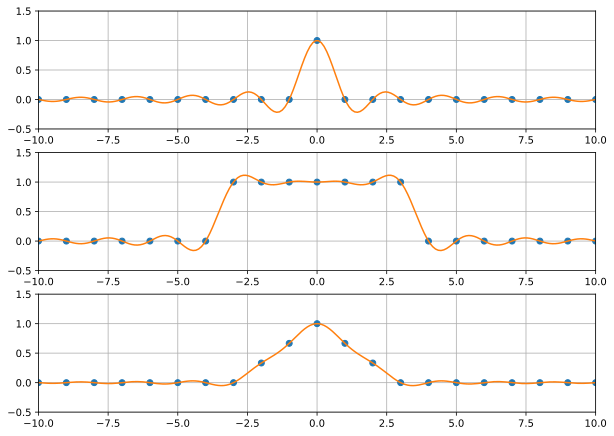

In [5]:
# Program 3: Band-limited interpolation
 
h = 1.0;
xmax = 10.0;
x = arange(-xmax,xmax+h,h)
xx = arange(-xmax-h/20, xmax+h/20, h/10)
figure(figsize=(10,10))
for pl in range(3):
    subplot(4,1,pl+1)
    if pl==0:
        v = (x==0)                      # delta function
    elif pl==1:
        v = (abs(x) <= 3.0)             # square wave
    else:
        v = maximum(0.0,1.0-abs(x)/3.0) # hat function
    plot(x,v,'o')
    grid(True)
    p = zeros(len(xx))
    for i in range(len(x)):
        p = p + v[i]*sin(pi*(xx-x[i])/h)/(pi*(xx-x[i])/h)
    plot(xx,p)
    axis([-xmax,xmax,-0.5,1.5]);

## Discrete Fourier Transform (2)

Continuous Fourier Transform,
$$g(t) \rightarrow G(f) = \int_{-\infty}^{\infty} g(t) \exp(i 2\pi ft) dt$$ 
is a linear one-to-one transform. 

We want to find its discrete analog. Assume that $g(t)$ is compactly supported (or periodic function) in $[0, Nh]$, with a little abuse of notation, $g=(g_0,...,g_{N-1})^t$ is the samples on the grid $\{kh\}$, $k=0,1, \cdots, N-1$ (N is even, if not we can add data 0).


Let G be the samples of G(f) in $(-\frac{1}{2h},\frac{1}{2h})$. $G$ can be obtained as follows. We choose N frequencies in this interval, for example, 
$$f_n =\frac{n}{Nh} , n= -\frac{N}{2}+1,...,\frac{N}{2}, f_{\frac{N}{2}}= \frac{1}{2h} = f_c$$
	
It is natural to introduce the one-to-one linear transform, such that, $\exists$ nonsingular matrix $M \in \mathbb{R}^{N\times N}$, $G=Mg$.    

**Exercise 3**
What are the modes with $f_{-\frac{N}{2}+1}$, $f_{\frac{N}{2}}$, and $f_n$ with $n$ small?  

We can estimate $G_n = G(f_n)$,
	
$$
	\begin{aligned}
	G_n &= \int_{-\infty}^{\infty} g(t) e^{(2\pi if_nt)} dt \\ 
	(\text{compactness}) & \approx \int_{0}^{Nh} g(t) e^{(2\pi if_nt)} dt \\
	(\text{discrete quadrature} )& \approx h \sum^{N-1}_{k=0} g_k e^{(2\pi i f_n t_k)} \\
	&=h \sum^{N-1}_{k=0} g_k e^{(2\pi i \frac{n}{Nh} kh)}\\
	&=h \sum^{N-1}_{k=0} g_k e^{2\pi i \frac{nk}{N}} 
	\end{aligned}
$$
	
	
	
In general, $h$ is a _scaling factor_, we can simply take $G_n= \sum^{N-1}_{k=0} g_k e^{2\pi i \frac{nk}{N}}$.

Since $e^{2\pi i \frac{(N+n)k}{N}} = e^{2\pi i \frac{nk}{N}}$, we have the following

**Property**
    $G_{n+N}=G_n$.
	
Therefore, we can define $G_n,n=0,...,N-1$ (instead of $n=-N/2+1, \cdots, N/2$), $G_n=\sum^{N-1}_{k=0} g_k e^{2\pi i \frac{nk}{N}}$
	
and 
	
$$   
	M=\left(          
	\begin{array}{ccccc}
    1 & 1 & ...&1\\  
	1 & \omega & ...& \omega^{(N-1)}\\  
	1 & \omega^2 & ...& \omega^{2(N-1)}\\  
	... & ... & ...& ...\\  
	1 & \omega^{N-1} & ...& \omega^{(N-1)^2}\\  	
    \end{array}
	\right)                
$$

But M is a dense matrix, and its computational cost is $O(N^2)$ 
	
**Definition**
	$g_k= \frac{1}{N} \sum_{h=0}^{N-1} G_n e^{-2\pi i \frac{kn}{N}}$ (Discrete Inverse Fourier Transform)
	
**Theorem**
	$ \sum_{k=0}^{N-1} |g_k|^2 = \frac{1}{N} \sum_{h=0}^{N-1} |G_n|^2$ (Discrete Parseval's Theorem)
    
**Exercise 4**
Verify the formula of discrete inverse Fourier transform, and prove discrete Parseval's theorem.

# Periodic spectral differentiation

We compute derivatives of following periodic functions on finite interval
$$
v(x) = \max(0, 1-|x-\pi|/2), \qquad x \in [0,2\pi]
$$
and
$$
v(x) = \exp(\sin(x)), \qquad x \in [0,2\pi]
$$

In [6]:
%matplotlib inline
%config InlineBackend.figure_format='svg'
from numpy import pi,inf,linspace,zeros,arange,sin,cos,tan,exp,maximum,abs
from numpy.linalg import norm
from scipy.linalg import toeplitz
from matplotlib.pyplot import figure,subplot,plot,axis,title,text

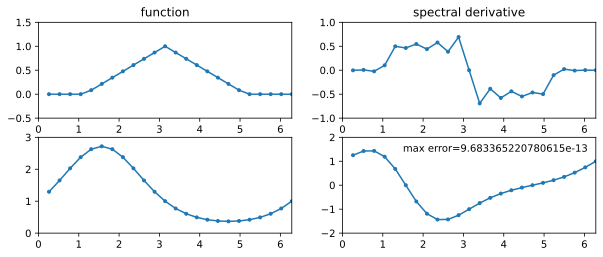

In [7]:
# Set up grid and differentiation matrix:
N = 24; h = 2*pi/N; x = h*arange(1,N+1);
col = zeros(N)
col[1:] = 0.5*(-1.0)**arange(1,N)/tan(arange(1,N)*h/2.0)
row = zeros(N)
row[0] = col[0]
row[1:] = col[N-1:0:-1]
D = toeplitz(col,row)

figure(figsize=(10,6))

# Differentiation of a hat function:
v = maximum(0,1-abs(x-pi)/2)
subplot(3,2,1)
plot(x,v,'.-')
axis([0, 2*pi, -.5, 1.5])
title('function')
subplot(3,2,2)
plot(x,D.dot(v),'.-')
axis([0, 2*pi, -1, 1])
title('spectral derivative')

# Differentiation of exp(sin(x)):
v = exp(sin(x)); vprime = cos(x)*v;
subplot(3,2,3)
plot(x,v,'.-')
axis([0, 2*pi, 0, 3])
subplot(3,2,4)
plot(x,D.dot(v),'.-')
axis([0, 2*pi, -2, 2])
error = norm(D.dot(v)-vprime,inf)
text(1.5,1.4,"max error="+str(error));